# Fitting with ChiSquare, Binned Likelihood, and Unbinned Likelihood

This is an introduction to likelihood fits, both binned and unbinned, trying to show the following points:
1. How likelihood fits work, both binned and unbinned.
2. When to use which type of fits, also including ChiSquare.
3. See how the amount of statistics influences the above choice.

Comparisons are naturally done with the ChiSquare. Also, this program serves as an introduction to fitting with iMinuit.

The exercise is made to play around with the (statistics of) the signal and background distributions, so that you can get a feel for the advantages and drawbacks of each method... and make sure that you feel comfortable in applying all three.


### Authors: 
- Troels C. Petersen (Niels Bohr Institute)
- Étienne Bourbeau (Niels Bohr Institute)

### Date:    
- 21-11-2020 (latest update)

### References:
- Barlow: 5.3 + 5.4 + 5.6
- Bevington: Chapter 10

***

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

# In case you want to load function from a jupyter notebook from the current working directory, you can use the function below:
#   from ipynb.fs.full.ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

Below are some of the general program settings, which are good to have in one place:

In [3]:
r = np.random # Random generator
r.seed(42)    # Set a random seed (but a fixed one)

save_plots = False # For now, don't save plots (once you trust your code, switch on)
verbose = True     # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10      # But only print a lot for the first 10 random numbers

## Create the data:

We create some data with a signal peak on an exponential background:

In [4]:
Npeak = 1000     # Number of random Gaussian points
Nexp  = 5000     # Number of random Exponential points

x_peak = r.normal(loc=3.14, scale=0.27, size=Npeak)
x_exp  = r.exponential(2.0, Nexp)
x_all = np.concatenate((x_peak, x_exp), axis=0)
if (verbose) :
    print(x_all)

[3.27411282 3.10266864 3.31487591 ... 0.7705041  4.05139454 4.26148115]


## Histogram of data:

Since we are considering both ChiSquare (chi2) and Binned Likelihood (bllh), we start with the histogram, which is the input for both of these. Of course, the Unbinned Likelihood (ullh) doesn't care about binning!

### Note on binning:
It is very important to specify - in a well thought manner - the range and binning to use. Many problems could have been avoided by a few minutes (or even seconds!) of consideration from the beginning. 

In [5]:
# General input:
Nbins = 100
xmin, xmax = 0, 10
binwidth = (xmax-xmin)/Nbins

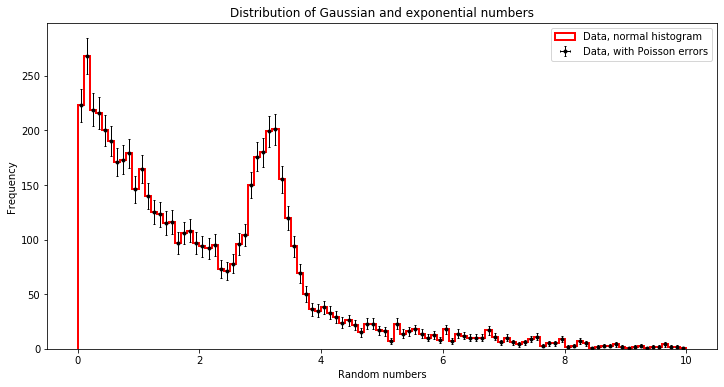

In [6]:
# Create just a single figure and axes
fig, ax = plt.subplots(figsize=(12, 6))  # figsize is in inches

# Create a (classic) histogram:
hist = ax.hist(x_all, bins=Nbins, range=(xmin, xmax), histtype='step', linewidth=2, color='red', label='Data, normal histogram')

# Find the x, y and error on y (sy) given the histogram:
counts, bin_edges = np.histogram(x_all, bins=Nbins, range=(xmin, xmax))
x = (bin_edges[1:] + bin_edges[:-1])/2
y = counts
sy = np.sqrt(counts)                         # NOTE: We (naturally) assume that the bin count is Poisson distributed.
# Now create a histogram with uncertainties (better, I would argue):
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='Data, with Poisson errors', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Random numbers", # the label of the y axis
       ylabel="Frequency",  # the label of the y axis
       title="Distribution of Gaussian and exponential numbers") # the title of the plot
ax.legend(loc='best'); # could also be # loc = 'upper right' e.g.

## Fit to the data / histogram (1D):

Having created the data, we now want to fit the distributions in three ways:
1. ChiSquare fit
2. Binned Likelihood fit
3. Unbinned Likelihood fit

We first define the function to be fitted with, a Gaussian and and Exponential PDF in this case:

In [7]:
# Define background PDF:
def exp_pdf(x, tau):
    """Exponential with lifetime tau"""
    return 1.0 / tau * np.exp(-x/tau)

In [8]:
# Define signal PDF:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1.0 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

In [9]:
# Define your actual fitting function, with both background and signal in,
# which is NOT normalised but has normalisation constants "N" in, and includes the bin width:
def fit_pdf(x, Nexp, tau, Ngauss, mu, sigma) :
    """Exponential + Gaussian"""
    return Nexp * binwidth * exp_pdf(x, tau) + Ngauss * binwidth * gauss_pdf(x, mu, sigma)

Having defined our fitting function, we now want to make three types of fits:
1: A ChiSquare fit.
2: A *binned likelihood* fit.
3: An *unbinned likelihood* fit.
Make sure that you understand the difference between the three.

It is important to use the same bins and bounds as the original histogram. In this case we are also treating the number of events/random numbers as being a fit variable which makes this a so-called *extended fit*.
***

# ChiSquare fit:

### Setting up a fit:

We initialize our fitting object, `chi2fit`, by using the `Chi2Regression` function from External Functions. You can also define your own Chi2 function (see introduction to plotting and fitting in Week0). This first takes the function to fit as input, then the input data.
Following this, we make a Minuit object, i.e. the minimisation itself. This is done using __[iMinuit](https://iminuit.readthedocs.io/en/latest/)__ which is a Python-wrapper for the wonderful minimization tool Minuit developed by CERN. Minuit requires the fitting object (here "chi2fit") and then GOOD input values (and possible value uncertainties, ranges, and fixing, etc. - see note below) and fitting options. Finally, we ask Minuit to actually find the minimum, and we have added a check to see, if this converged or not.

In [10]:
chi2fit = Chi2Regression(fit_pdf, x, y, sy)
minuit_chi2 = Minuit(chi2fit, Nexp=5000, tau=2.0, Ngauss=1000.0, mu=3.1, sigma=0.3, pedantic=False, print_level=1)
minuit_chi2.migrad();

if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

------------------------------------------------------------------
| FCN = 89.96                   |     Ncalls=108 (108 total)     |
| EDM = 1.66e-06 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


#### Extracting fit results:

In [16]:
# Short hand way of accessing the fit parameters:
fit_Ngauss, fit_mu, fit_sigma, fit_Nexp, fit_tau = minuit_chi2.args   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters:
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

chi2_prob = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {chi2_prob:5.3f}")

Fit value: Nexp = 4867.10003 +/- 77.01033
Fit value: tau = 1.89789 +/- 0.03077
Fit value: Ngauss = 1037.57446 +/- 44.94147
Fit value: mu = 3.15111 +/- 0.01280
Fit value: sigma = 0.27389 +/- 0.01193
Chi2 value: 90.0   Ndof = 95    Prob(Chi2,Ndof) = 0.627


#### Note on options for Minuit:

When defining the minimisation object, we give the fit initial values for `Ngauss`, `mu`, `sigma`, and `Nexp` and `tau`. Also, we disables some automatic warnings that Minuit shows (which are unimportant in most cases) but ask it to print out the details of the minimisation result (but not the parameters).

In passing the (crucial) initial parameters, there are a few useful options:
1. Giving an uncertainty on the initial value of X, done with the prefix "error_" (i.e. "error_X = uncertainty").
2. Giving a range of allowed values for X, done with the prefix "limit_" (i.e. "limit_X) = (min,max)").
3. Fixing X to a certain value, done with the prefix "fix_" (i.e. "fix_X=True").

In the text below here we show examples of how to implement the above:
``` 
minuit = Minuit(chi2fit, Nexp=5000, tau=2.0, Ngauss=1000.0, mu=3.1, sigma=0.3, pedantic=False, print_level=1,
                error_tau = 0.2,       # Tell the fit how certain you are of the initial value for tau
                limit_mu = (0,10),     # Set the range for 'mu' to be between 0 and 10
                fix_N=True             # fix the value of N to its initial value (here 5000)
                )
```

**Word of warning on parameter limits**: Giving a (reasonable) uncertainty on the input parameter is a help to Minuit, and fixing a parameter generally makes the fit convergence easier (and is a good way to build up and check a complicated fit). However, setting limits can be troublesome, as this results in an internal transformation of variables, which affects both convergence and uncertainty estimates. One should therefore avoid using limits, and if doing it anyway and succeeding, remove them once the fit has converged, given that good initial values are now established.

# Binned Likelihood fit:

Next we try to fit the same data with the same function in a *binned likelihood fit*. Note that the fitting object now takes the x-values themselves (not a histogram), but requires numbers of bins and a range/bound.

In [12]:
bllhfit = BinnedLH(fit_pdf, x_all, bins=Nbins, bound=(xmin, xmax), extended=True)
minuit_bllh = Minuit(bllhfit, Nexp=5000, tau=2.0, Ngauss=1000.0, mu=3.1, sigma=0.3, pedantic=False, print_level=1)
minuit_bllh.migrad();          # Perform the actual fit

if (not minuit_bllh.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

------------------------------------------------------------------
| FCN = 42.76                   |     Ncalls=253 (253 total)     |
| EDM = 2.54e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


# Unbinned Likelihood fit:

For the *unbinned likelihood fit*, the input is again the x-values themselves, and bounds are possible, but no binning is suggested, as this is... well... unbinned.

In [13]:
ullhfit = UnbinnedLH(fit_pdf, x_all, bound=(xmin, xmax), extended=True)
minuit_ullh = Minuit(ullhfit, Nexp=5000, tau=2.0, Ngauss=1000.0, mu=3.1, sigma=0.3, pedantic=False, print_level=1)
minuit_ullh.migrad();          # Perform the actual fit

if (not minuit_ullh.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    

------------------------------------------------------------------
| FCN = -3.604e+04              |     Ncalls=282 (282 total)     |
| EDM = 4.81e-06 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


# Questions:

1) Start by drawing the three fits on top of the data. Do they (by eye) give the same result, and does the fit generally look "good"?

2) Now print the fitted values, and see if they all agree within uncertainties.

3) To what extend do the three methods give the same results when varying the input parameters, especially when the number of signal and background events is low? I.e. repeat question 1) and 2) for lower statistics cases, for example Ngauss = 10 and Nexp = 50.

### Advanced question:

4) Knowing the PDFs used for producing the data, try to see, if you can produce a goodness-of-fit measure for the unbinned likelihood fit by repeating this type of fit many times. 